# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import os
os.chdir('../')

import datetime
from pathlib import Path

import numpy as np

import torch

from collections import deque

import matplotlib.pyplot as plt

from unityagents import UnityEnvironment

from p1_navigation.agents.agent_dqn import AgentDQN

In [2]:
SEED = 42
SCORE_TARGET = 15.0
SCORE_WINDOW = 100

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Set seeds
torch.manual_seed(SEED)
np.random.seed(SEED)

# create folder architecture
PROJECT = 'p1_navigation'
START_TIME = datetime.datetime.now().strftime('%m-%d-%Y_%Hh%Mm')
EXPERIMENT_FOLDER = f'{PROJECT}/experiments/{START_TIME}'
Path(EXPERIMENT_FOLDER).mkdir(parents=True, exist_ok=False)

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [3]:
env_path = f'{PROJECT}/Banana_Linux/Banana.x86_64'
env = UnityEnvironment(file_name=env_path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Algorithm

The algorithm chosen for this task is DQN, since it is a value-based method that works well with discrete action spaces, as in our case.

DQN improves the traditional Q-learning for huge observation spaces by using deep learning: the value function is estimated by a neural network, efficiently leveraging the huge amount of observations present in most real-world/complex tasks. By making use of an epsilon-greedy policy, this off-policy algorithm has been successfully used for solving many tasks. Moreover, the neural network can be of convolutional type, therefore allowing for an end-to-end approach, learning directly from images.

In addition to this, several hyperparameters have been chosen for training the agent:

**Networks parameters**:
Two hidden full convolutional layers, consisting in 75% and 50% of the observation spaces as units, respectively.

**Hyperparameters**:
- batch_size = 64         # minibatch size
- buffer_size = int(1e5)  # replay buffer size
- learn_every = 2         # how often to learn
- gamma = 0.99            # discount factor
- tau = 1e-3              # for soft update of target parameters
- lr = 5e-4               # learning rate
- epsilon = 0.05          # for e-greedy policy

In [6]:
# define the agent
agent = AgentDQN(
    state_size=state_size,
    action_size=action_size,
    hyperparams=dict(),
    device=DEVICE,
    seed=SEED
)

### 4. Training

In [7]:
# training hyperparameters
n_episodes = 1000  # maximum number of training episodes
max_t = 1000       # maximum number of timesteps per episode
eps_start = 1.0    # starting value of epsilon, for epsilon-greedy action selection
eps_end = 0.01     # minimum value of epsilon
eps_decay = 0.995  # multiplicative factor (per episode) for decreasing epsilon
eps = eps_start    # initialize epsilon

scores = []                                 # scores for each episode
scores_window = deque(maxlen=SCORE_WINDOW)  # last 100 scores
scores_window_means = []                    # average max scores for each episode

# training loop
for i_episode in range(1, n_episodes + 1):
    env_info = env.reset(train_mode=True)[brain_name]  # reset environment
    state = env_info.vector_observations[0]  # get the current state
    score = 0                                # reset score

    for t in range(max_t):
        action = agent.select_action(state, eps)      # get the action from the agent
        env_info = env.step(action)[brain_name]       # send the action to the environment
        next_state = env_info.vector_observations[0]  # get the next state
        reward = env_info.rewards[0]                  # get the reward
        done = env_info.local_done[0]                 # see if episode has finished

        # save experience tuple into replay buffer
        agent.step(state, action, reward, next_state, done)

        state = next_state  # roll over states to next time step
        score += reward     # update the scores

        if done:
            break

    eps = max(eps_end, eps_decay * eps)  # decrease epsilon

    scores.append(score)
    scores_window.append(score)

    window_score_mean = np.mean(scores_window)  # save mean of window scores
    scores_window_means.append(window_score_mean)

    print(
        '\rEpisode {}\tEpisode total score: {:.2f}\tWindow Score: {:.2f}'
        .format(i_episode, score, window_score_mean),
        end=""
    )

    if i_episode % 100 == 0:
        print(
            '\rEpisode {}\tWindow Score: {:.2f}'
            .format(i_episode, window_score_mean)
        )

    if window_score_mean >= SCORE_TARGET:
        print(
            '\nEnvironment solved in {:d} episodes!\tWindow Score: {:.2f}'
            .format(i_episode, window_score_mean)
        )

        print(f'Saving weights into {EXPERIMENT_FOLDER} folder...')
        torch.save(
            agent.qnetwork_local.state_dict(),
            f'{EXPERIMENT_FOLDER}/weights_actor_episode_{i_episode}.pth'
        )

        break

Episode 100	Window Score: 0.82e: 3.00	Window Score: 0.823
Episode 200	Window Score: 3.59e: 3.00	Window Score: 3.598
Episode 300	Window Score: 7.88e: 6.00	Window Score: 7.885
Episode 400	Window Score: 10.19: 12.00	Window Score: 10.19
Episode 500	Window Score: 12.87: 11.00	Window Score: 12.87
Episode 600	Window Score: 13.80: 11.00	Window Score: 13.80
Episode 700	Window Score: 14.55: 19.00	Window Score: 14.55
Episode 737	Episode total score: 15.00	Window Score: 15.02
Environment solved in 737 episodes!	Window Score: 15.02
Saving weights into p1_navigation/experiments/04-26-2020_21h09m folder...


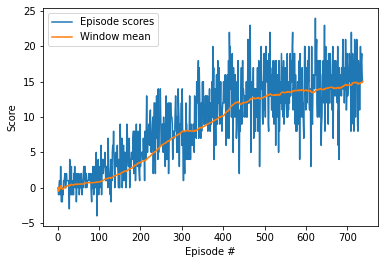

Saving figure into p1_navigation/experiments/04-26-2020_21h09m folder...


In [8]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores, label='Episode scores')
plt.plot(np.arange(1, len(scores) + 1), scores_window_means, label='Window mean')
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# save figure to file
print(f'Saving figure into {EXPERIMENT_FOLDER} folder...')
fig.savefig(f'{EXPERIMENT_FOLDER}/scores.png')

In [9]:
# close the environment
env.close()

### 5. Future work

#### 5.1. Further improvements

The agent current performs better than Udacity's provided solution, but still has space for improvement. It is likely that by performing architecture search and tuning both *tau* and *gamma* the performance of the agent can increase. In addition, learning from pixels allow a more complex input in the network, thus slowing learning but improving generalization and adaption to complex situations.

#### 5.2. Other algorithms

Other algorithms that I think could be interesting to benchmark with DQN are SARSA and, additionally, Actor-Critic methods, previous adaptation to work with discrete action spaces, which I personally think are going to perform worse.

### 6. References

**DQN paper**: https://www.nature.com/articles/nature14236

**DQN explanation**: https://medium.com/analytics-vidhya/building-a-powerful-dqn-in-tensorflow-2-0-explanation-tutorial-d48ea8f3177a

**DQN implementation**: https://github.com/udacity/deep-reinforcement-learning